# Plotting and analyzing NAMD results

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Plotting the results](#plotting)\
   3.1. [Average decoherence times map](#ene_time)\
   3.2. [NAMD results](#namd_res)
   
### A. Learning objectives

* To be able to plot the decoherence times map
* To be able to plot and analyze NAMD results

### B. Use cases


* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Import `numpy`, `h5py`, `units`, and `scipy.optimize.curve_fit` will be used to fit the NAMD results.

In [14]:
import os
import glob
import h5py
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from libra_py import units

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

We require all the NAMD results for different methods stored in `mem_data.hdf` files in `F'{method}_NBRA_icond_{icond}'` folders e.g. `FSSH_NBRA_icond_0/mem_data.hdf`.

## 3. Plotting the results <a name="plotting"></a>
[Back to TOC](#toc)


### 3.1. Average decoherence time map <a name="ene_time"></a>



<IPython.core.display.Javascript object>


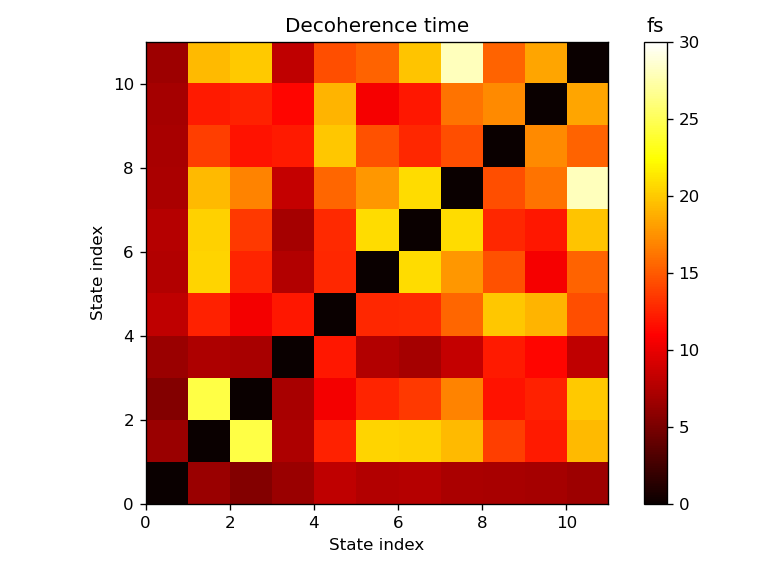

In [16]:
%matplotlib notebook
plt.figure()
avg_deco = np.loadtxt('avg_deco.txt')
nstates = avg_deco.shape[0]
plt.imshow(np.flipud(avg_deco), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
colorbar = plt.colorbar()
colorbar.ax.set_title('fs')
plt.clim(vmin=0, vmax=30)
plt.title(F'Decoherence time')
plt.tight_layout()

### 3.2. NAMD results <a name="namd_res"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results using `h5py` and start fitting them to a exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^2)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.1$. The error bars are computed using the following formula as above:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.1$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In above, we will consider the recovery dynamics population of the first and second excited states. Also, please note that this is just an example and we want to show how the fitting works. So, we consider a low $R^2$ value. For better and more accurate results, we need not only longer dynamics but also larger number of surface hopping trajectories.


In [17]:
def exp_func(t, tau):
    return np.exp(-np.power(t/tau,2))

<IPython.core.display.Javascript object>


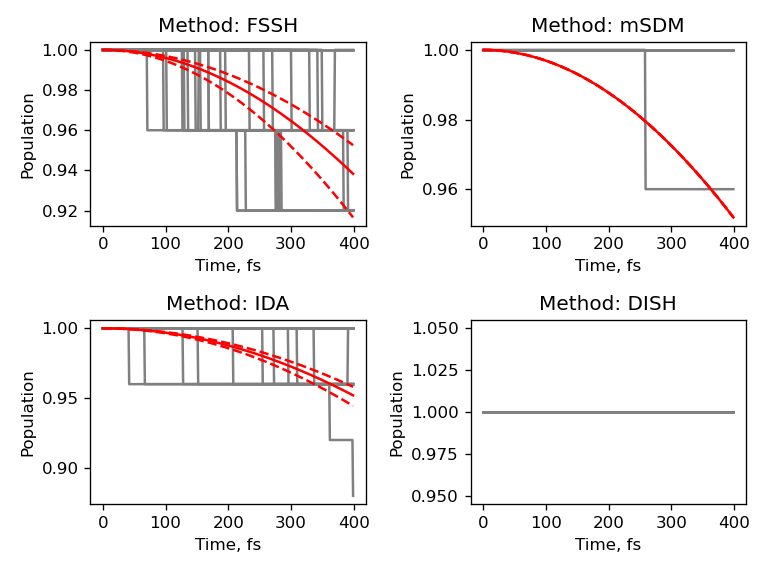

/projects/academic/alexeyak/mohammad/software/mc/envs/libra/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


The timescales for method FSSH: 1581.0724339758942+-229.0325561630532 fs, averaged over 17 samples
The timescales for method mSDM: 1796.913375305052+-0.0 fs, averaged over 1 samples
The timescales for method IDA: 1798.879256388155+-129.780697047316 fs, averaged over 8 samples
The timescales for method DISH: nan+-nan fs, averaged over 0 samples


In [19]:
%matplotlib notebook
dt = 1
for c, method in enumerate(['FSSH', 'mSDM', 'IDA', 'DISH']):
    taus = []
    plt.subplot(2,2,c+1)
    for icond in range(0,200,10):
        F = h5py.File(F'{method}_NBRA_icond_{icond}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        F.close()
        md_time = np.arange(0,sh_pop.shape[0])*dt
        pop_recov = 1-np.sum(sh_pop[:,[1,2]], axis=1)
        popt, pcov = curve_fit( exp_func, md_time, pop_recov, bounds=([0.0],[np.inf]))
        tau = popt
        # Computing the R-squared
        residuals  = pop_recov - exp_func(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((pop_recov - np.mean(pop_recov))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        #print('tau:', tau,  ' R2:', r_squared)

        if r_squared>0.1:
            taus.append(tau)
        plt.plot(md_time, pop_recov, color='gray')
    plt.ylabel('Population')
    plt.xlabel('Time, fs')
    plt.title(F'Method: {method}')
    
    taus = np.array(taus)
    ave_tau = np.average(taus)
    s = np.std(taus)
    Z = 1.96
    N = taus.shape[0]
    error_bar = Z*s/np.sqrt(N)
    print(F'The timescales for method {method}: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
    plt.plot(md_time, exp_func(md_time, ave_tau-error_bar), ls='--', color='red')
    plt.plot(md_time, exp_func(md_time, ave_tau), ls='-',  color='red')
    plt.plot(md_time, exp_func(md_time, ave_tau+error_bar), ls='--', color='red')
    
    plt.tight_layout()

`NAN` values show that the dynamics has no decay.